# nuScenes Map Expansion Tutorial

This is the tutorial for the nuScenes map expansion. In particular, the `NuScenesMap` data class. 

This tutorial will go through the description of each layers, how we retrieve and query a certain record within the map layers, render methods, and advanced data exploration

In database terms, layers are basically tables of the map database in which we assign arbitrary parts of the maps with informative labels such as `traffic_light`, `stop_line`, `walkway`, etc. Refer to the discussion on layers for more details.

### Setup
To install the map expansion, please download the files from https://www.nuscenes.org/download and copy the files into your nuScenes map folder, e.g. `/data/sets/nuscenes/maps`.

### Initialization

We will be working with the `singapore-onenorth` map. The `NuScenesMap` can be initialized as follows:

In [22]:
import matplotlib.pyplot as plt
from nuscenes.map_expansion.map_api import NuScenesMap

nusc_map = NuScenesMap(dataroot='/data/sets/nuscenes', map_name='singapore-onenorth')

## Visualization

Before we go into the details, let's visualize the map.

### Rendering multiple layers

The `NuScenesMap` class makes it possible to render multiple map layers on a matplotlib figure.

In [23]:
nusc_map.non_geometric_layers

['drivable_area',
 'road_segment',
 'road_block',
 'lane',
 'ped_crossing',
 'walkway',
 'stop_line',
 'carpark_area',
 'road_divider',
 'lane_divider',
 'traffic_light']

ValueError: A polygon or multi-polygon representation is required

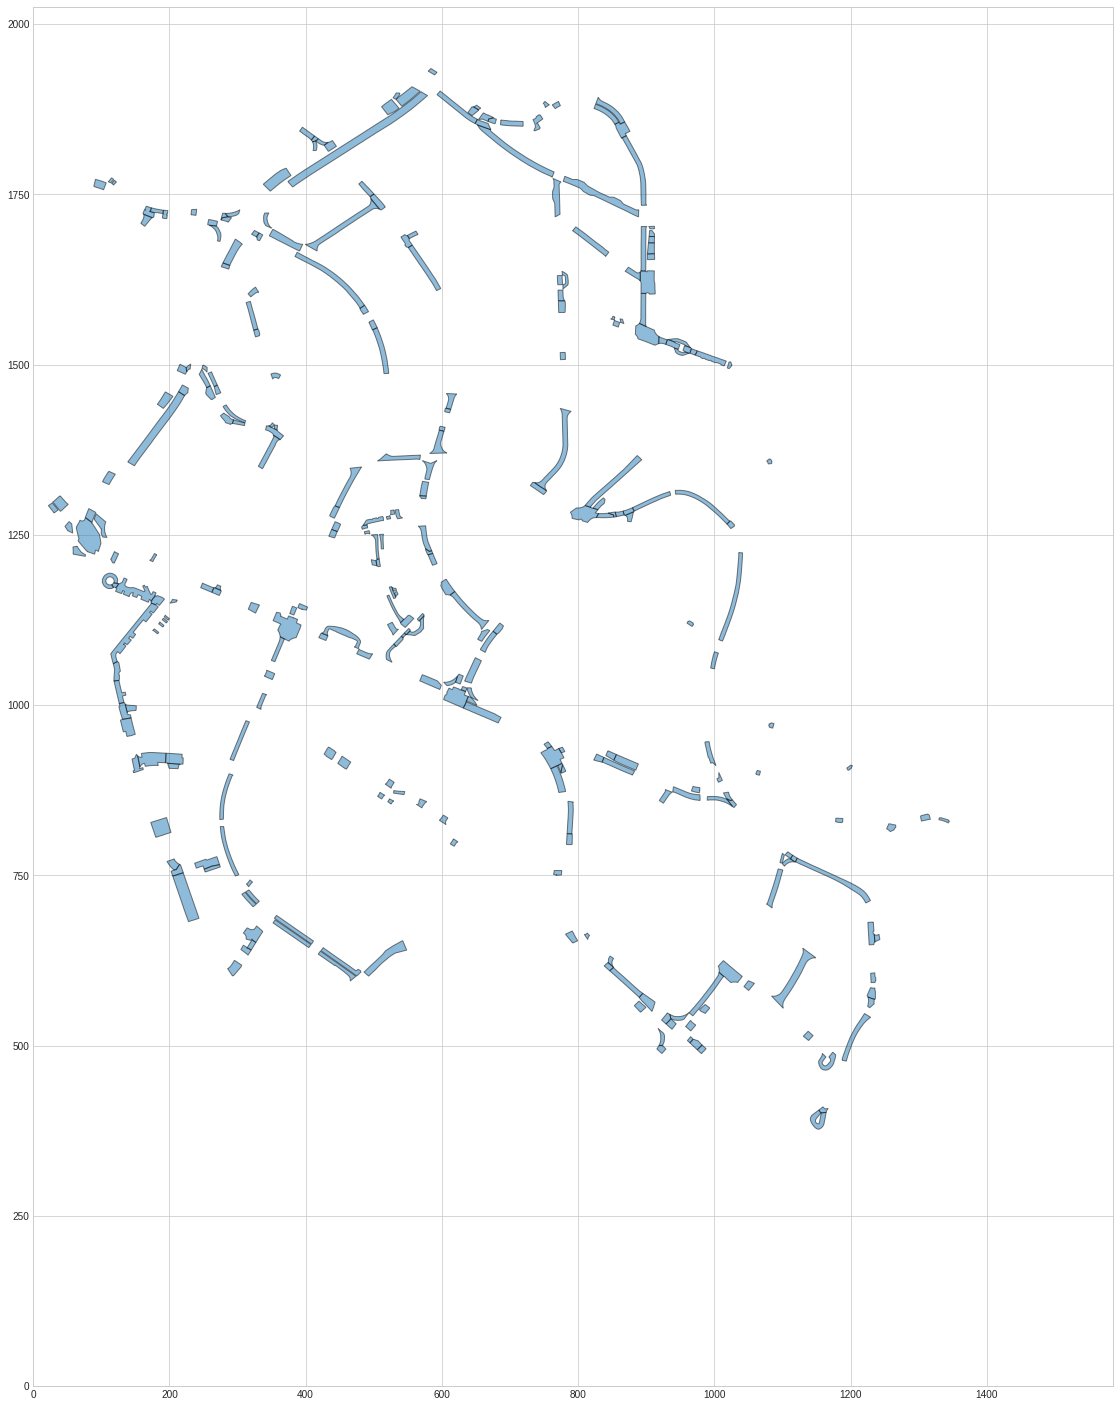

In [24]:
fig, ax = nusc_map.render_layers(['road_segment'], figsize=(15, 15))

### Rendering a particular record of the map layer

We can render a record, which will show its global and local view

ValueError: A polygon or multi-polygon representation is required

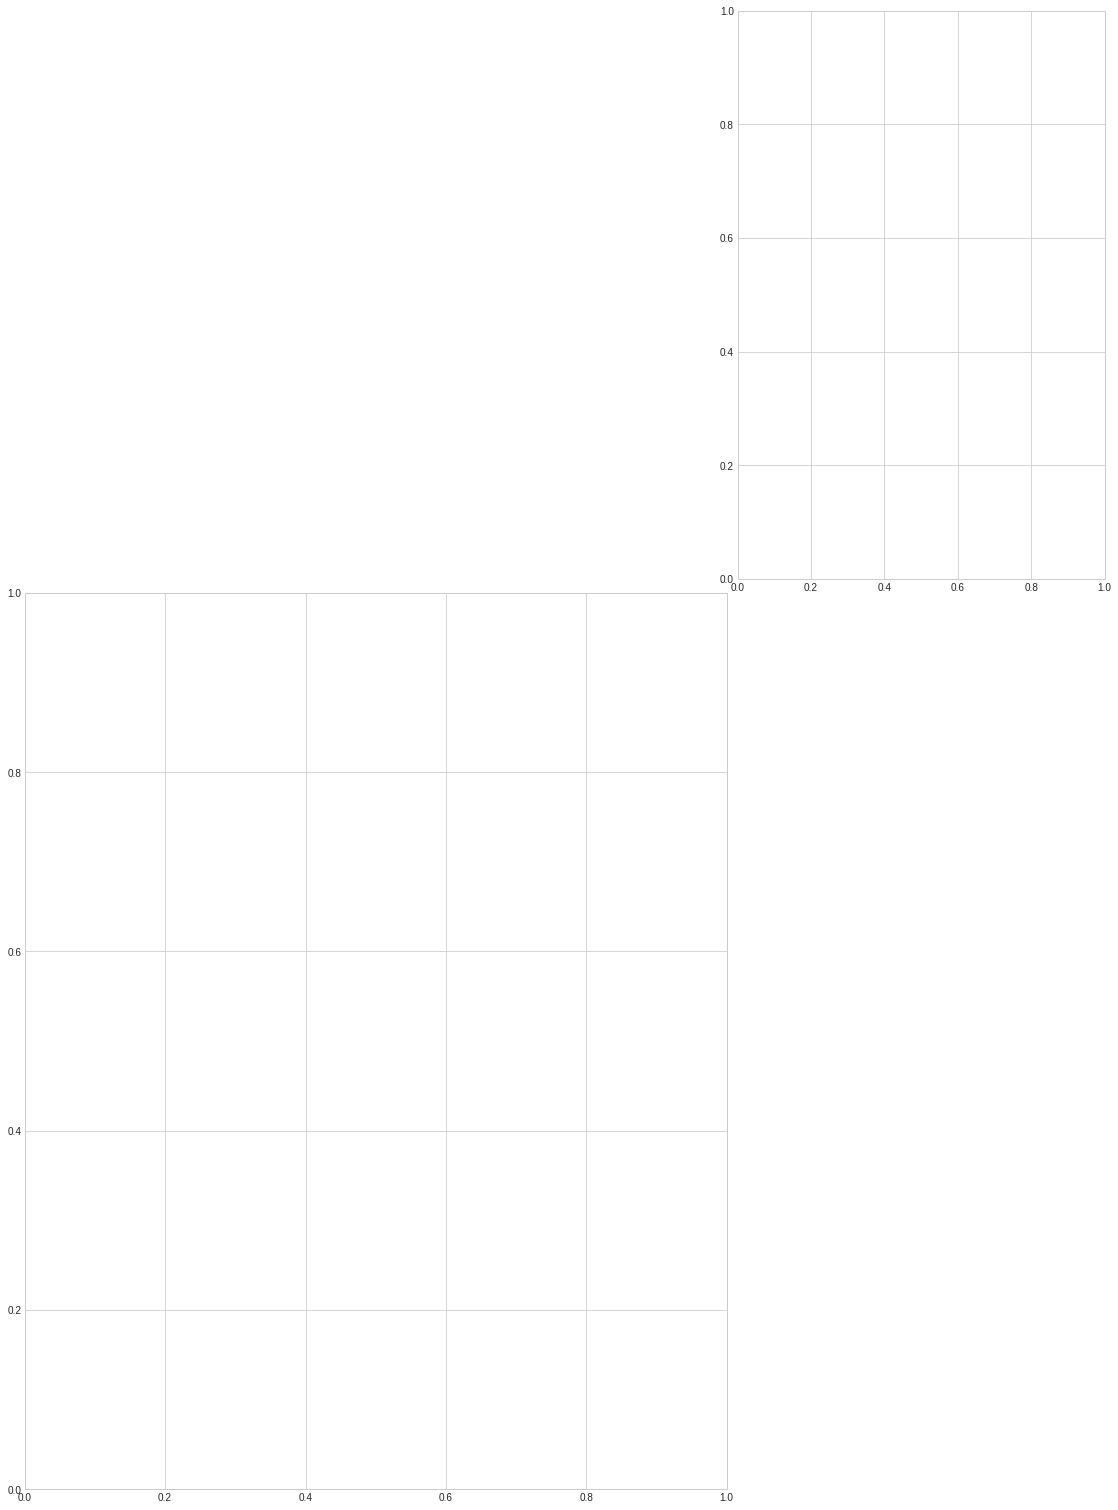

In [4]:
fig, ax = nusc_map.render_record('road_segment', nusc_map.road_segment[600]['token'], other_layers=[])

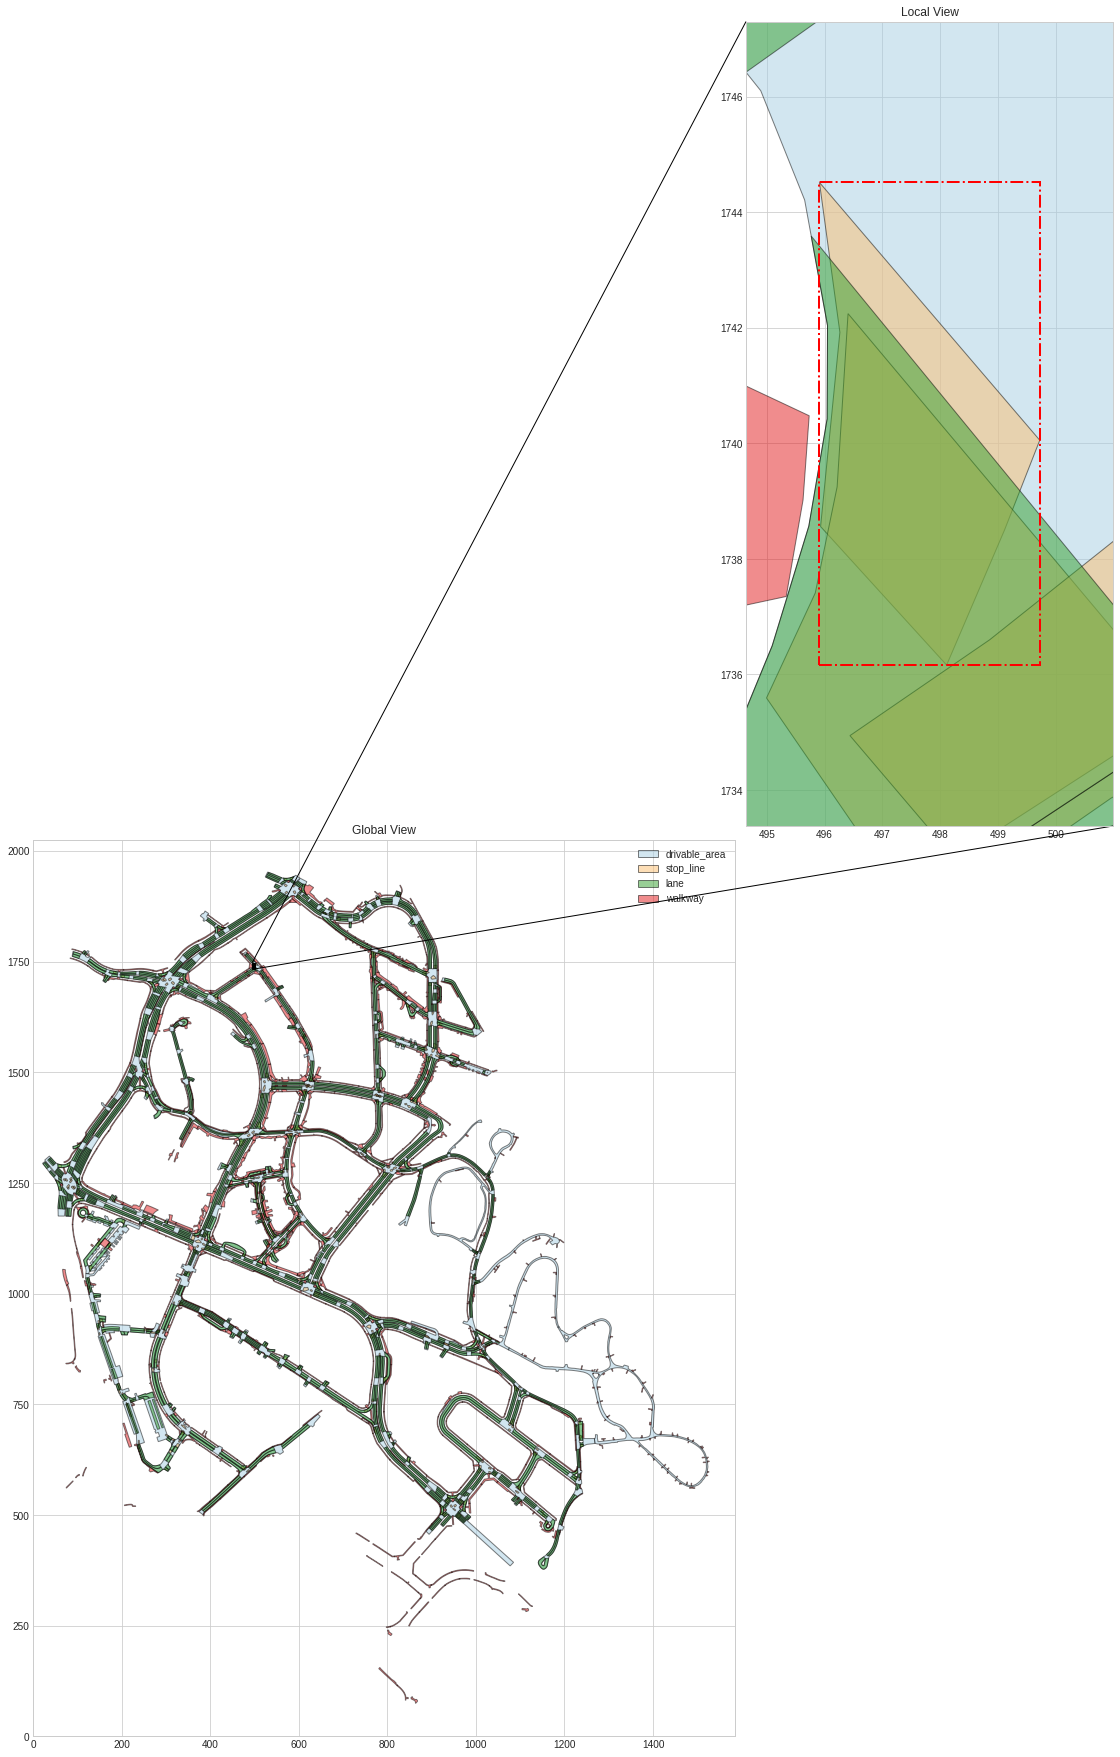

In [5]:
fig, ax = nusc_map.render_record('stop_line', nusc_map.stop_line[14]['token'])

### Rendering binary map mask layers

The `NuScenesMap` class makes it possible to convert multiple map layers into binary mask and render on a Matplotlib figure. First let's call `get_map_mask` to look at the raw data of two layers:

In [6]:
patch_box = (300, 1700, 100, 100)
patch_angle = 0  # Default orientation where North is up
layer_names = ['drivable_area', 'ped_crossing']
canvas_size = (1000, 1000)
map_mask = nusc_map.get_map_mask(patch_box, patch_angle, layer_names, canvas_size)
map_mask[0]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]], dtype=uint8)

Now we directly visualize the map mask retrieved above using `render_map_mask`:

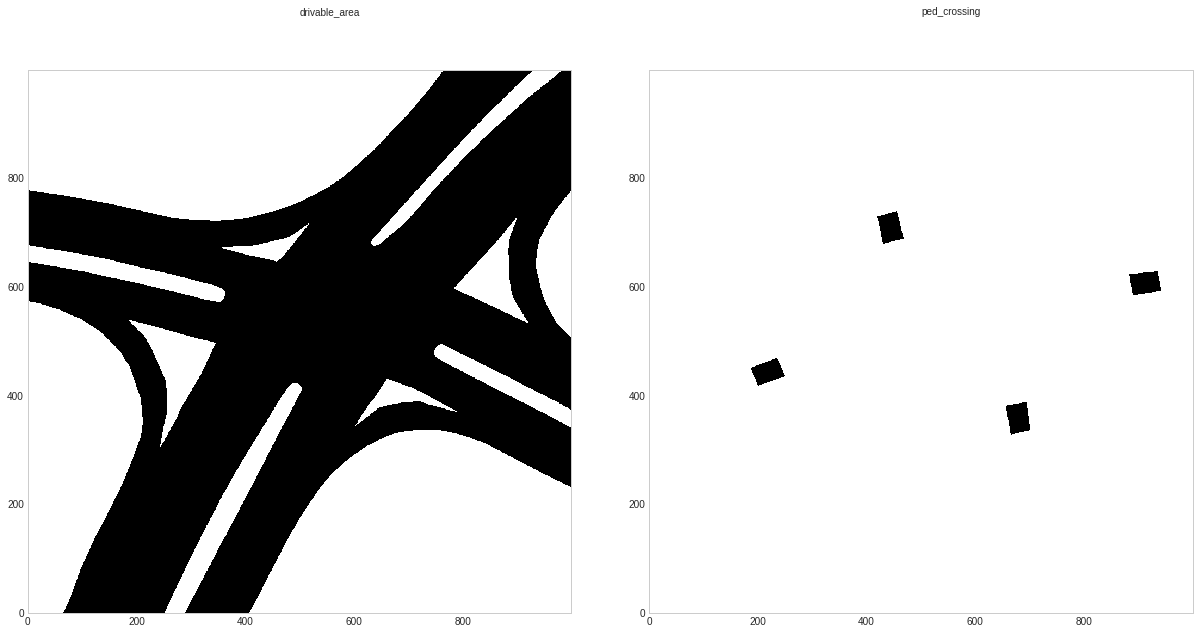

In [7]:
figsize = (22, 10)
fig, ax = nusc_map.render_map_mask(patch_box, patch_angle, layer_names, canvas_size, figsize=figsize, n_row=1)

We can also render the same map rotated by 45 degrees clockwise:

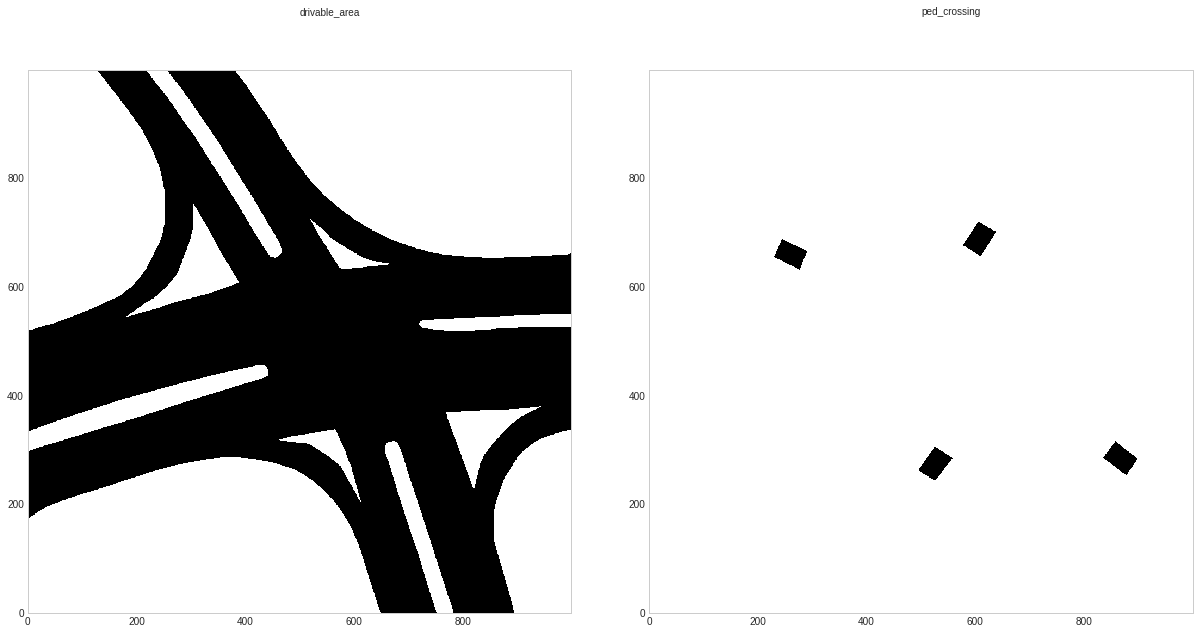

In [8]:
fig, ax = nusc_map.render_map_mask(patch_box, 45, layer_names, canvas_size, figsize=figsize, n_row=1)

### Rendering map layers on top of camera images
Let us take a nuScenes camera image and overlay the relevant map layers.
Note that the projections are not perfect if the ground is uneven as the localization is 2d.

In [9]:
# Init nuScenes. Requires the dataset to be stored on disk.
from nuscenes.nuscenes import NuScenes
nusc = NuScenes(version='v1.0-mini', verbose=False)

# Pick a sample and render the front camera image.
sample_token = nusc.sample[9]['token']
layer_names = ['road_segment', 'lane', 'ped_crossing', 'walkway', 'stop_line', 'carpark_area']
camera_channel = 'CAM_FRONT'
nusc_map.render_map_in_image(nusc, sample_token, layer_names=layer_names, camera_channel=camera_channel)

FileNotFoundError: [Errno 2] No such file or directory: '/data/sets/nuscenes/samples/CAM_FRONT/n015-2018-07-24-11-22-45+0800__CAM_FRONT__1532402932162460.jpg'

### Rendering ego poses on the map
We can also plot the ego poses onto the map. This requires us to load up the `NuScenes` class, which can take some time.

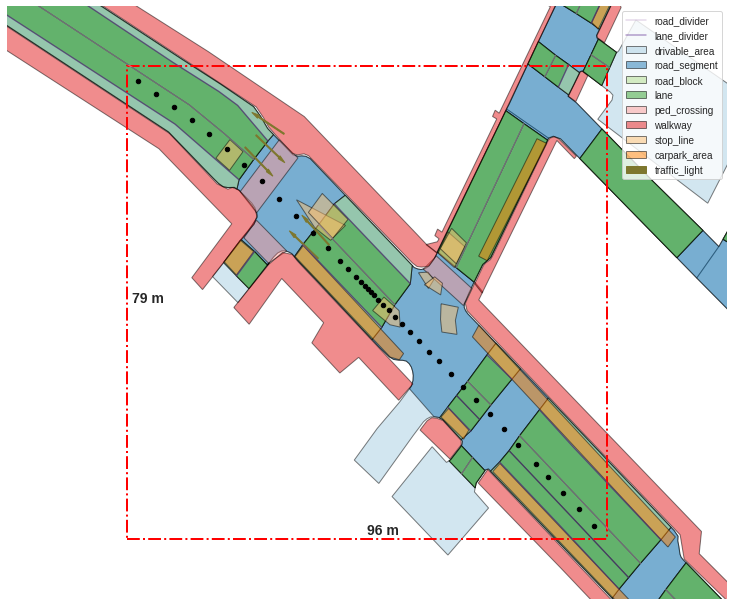

In [10]:
# Init NuScenes. Requires the dataset to be stored on disk.
from nuscenes.nuscenes import NuScenes
nusc = NuScenes(version='v1.0-mini', verbose=False)

# Render ego poses.
nusc_map_bos = NuScenesMap(dataroot='/data/sets/nuscenes', map_name='boston-seaport')
ego_poses = nusc_map_bos.render_egoposes_on_fancy_map(nusc, scene_tokens=[nusc.scene[1]['token']], verbose=False)

## Navigation
We also provide functions for navigation around the road network. For this purpose, the road layers `lane`, `road_block` and `road_segment` are especially useful (see definitions below). The `get_next_roads(x, y)` function looks at the road layer at a particular point. It then retrieves the next road object in the direction of the `lane` or `road_block`. As `road_segments` do not have a direction (e.g. intersections), we return all possible next roads.

In [11]:
x = 873
y = 1286
print('Road objects on selected point:', nusc_map.layers_on_point(x, y), '\n')
print('Next road objects:', nusc_map.get_next_roads(x, y))

Road objects on selected point: {'drivable_area': 'c3e28556-b711-4581-9970-b66166fb907d', 'road_segment': '57416e99-8919-4a28-985b-033a16938243', 'road_block': '', 'lane': '', 'ped_crossing': '', 'walkway': '', 'stop_line': '', 'carpark_area': ''} 

Next road objects: {'road_segment': ['3493d68c-5217-4d21-ae1b-3cbf4467dd77', '4b0e50c0-c549-49a2-9077-57a8cba8ab55', '5428b143-6343-4045-ac81-466df3dcc510'], 'road_block': ['5c286ee8-7b4d-4cd8-84bb-7486e77ba827', '8b33213a-692e-4c5f-a69a-efa6836f5316', '9aa7a714-30ba-4892-a276-c033928a8ae2', '9c506cc4-7d14-475d-8063-22a5b9bc257f', 'b7cc94f4-3882-4df2-a9ae-9349925809a1', 'e0c4f027-ea81-40f2-bafc-3fb8e8ab78c3'], 'lane': ['525b6716-a12e-4dd0-8541-91ef672ce39b', '5fdd162d-477d-4bc4-ada3-535d79a9f4b1', '8658217b-87d6-4f8b-96be-35d53100247d', 'b7378bda-dedf-4f97-9d87-b0dd602fdab5', 'bce7caf7-5e33-48d6-b0aa-8b5b641c8ce5', 'f747ce8a-2396-4da3-a8e6-45201ed470d6']}


We can also visualize the next roads using the `render_next_roads(x, y)` function. We see that there are 3 adjacent roads to the intersection specified by (x, y).

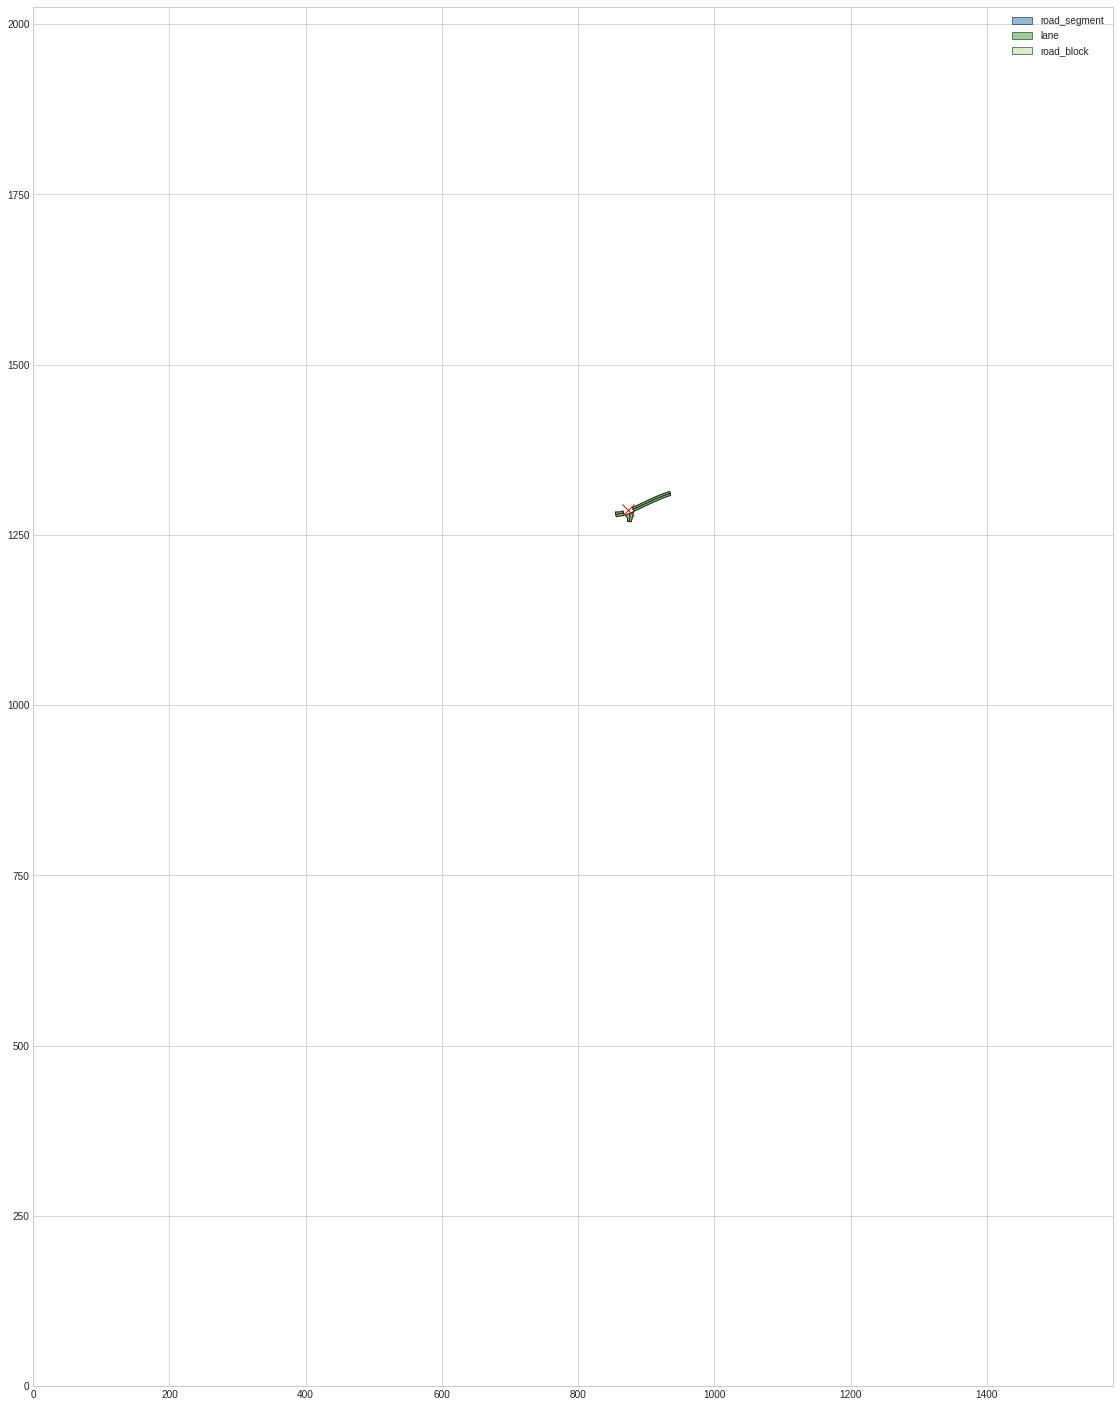

In [12]:
nusc_map.render_next_roads(x, y)

## Working with Lanes

To get the closest lane to a location, use the `get_closest_lane` method. To see the internal data representation of the lane, use the `get_lane_record` method. 
You can also explore the connectivity of the lanes, with the `get_outgoing_lanes` and `get_incoming_lane` methods.

In [ ]:
x, y, yaw = 395, 1095, 0
closest_lane = onenorth.get_closest_lane(x, y, radius=2)
closest_lane

In [ ]:
lane_record = onenorth.get_lane(closest_lane)
lane_record

In [ ]:
onenorth.get_incoming_lane_ids(closest_lane)

In [ ]:
onenorth.get_outgoing_lane_ids(closest_lane)

To help manipulate the lanes, we've added an `arcline_path_utils` module. For example, something you might want to do is discretize a lane into a sequence of poses.

In [ ]:
from nuscenes.map_expansion import arcline_path_utils
poses = arcline_path_utils.discretize_lane(lane_record, resolution_meters=1)
poses

Given a query pose, you can also find the closest pose on a lane.

In [ ]:
closest_pose_on_lane, distance_along_lane = arcline_path_utils.project_pose_to_lane((x, y, yaw), lane_record)

In [ ]:
print(x, y, yaw)
closest_pose_on_lane

In [ ]:
# Meters
distance_along_lane

To find the entire length of the lane, you can use the `length_of_lane` function.

In [ ]:
arcline_path_utils.length_of_lane(lane_record)

You can also compute the curvature of a lane at a given length along the lane.

In [ ]:
# 0 means it is a straight lane
arcline_path_utils.get_curvature_at_distance_along_lane(distance_along_lane, lane_record)

## Data Exploration

Let's render a particular patch on the map:

In [ ]:
my_patch = (300, 1000, 500, 1200)
fig, ax = nusc_map.render_map_patch(my_patch, nusc_map.non_geometric_layers, figsize=(10, 10))

A lot of layers can be seen in this patch. Lets retrieve all map records that are in this patch.

- The option `within` will return all non geometric records that ***are within*** the map patch
- The option `intersect` will return all non geometric records that ***intersect*** the map patch


In [ ]:
records_within_patch = nusc_map.get_records_in_patch(my_patch, nusc_map.non_geometric_layers, mode='within')
records_intersect_patch = nusc_map.get_records_in_patch(my_patch, nusc_map.non_geometric_layers, mode='intersect')

Since there are a lot of records, we focus only on the layer `road_segment`:

In [ ]:
layer = 'road_segment'
print('Found %d records of %s (within).' % (len(records_within_patch[layer]), layer))
print('Found %d records of %s (intersect).' % (len(records_intersect_patch[layer]), layer))

We see that using the option `intersect` typically returns more records than `within`.

Looking at the above plot. Point `(390, 1100)` seems to be on a stop line. Lets verify that.

In [ ]:
my_point = (390, 1100)
layers = nusc_map.layers_on_point(my_point[0], my_point[1])
assert len(layers['stop_line']) > 0, 'Error: No stop line found!'

Indeed, we see a `stop_line` record.

To directly check for `stop_line` records, we run:

In [ ]:
nusc_map.record_on_point(my_point[0], my_point[1], 'stop_line')

Let's look at the bounds/extremities of that record

In [ ]:
nusc_map.get_bounds('stop_line', 'ac0a935f-99af-4dd4-95e3-71c92a5e58b1')

## Layers

Let us look more closely at the different map layers:

In [ ]:
nusc_map.layer_names

Our map database consists of multiple **layers**. Where each layer is made up of **records**. Each record will have a token identifier.

We see how our map layers are divided into two types of layers. One set of layer belong to the `geometric_layers` group, another set of layers belongs to the `non_geometric_layers` group.  
1. `geometric_layers` define geometric entities in the map:
    - Nodes (2d points) are the basis for all geometric layers.
    - Lines consist of two or more nodes. Formally, one `Line` record can consist of more than one line segment.
    - Polygons consist of three or more nodes. A polygon can have holes, thus distorting its formal definition. Holes are defined as a sequence of nodes that forms the perimeter of the polygonal hole.
    
    
2. `non_geometric_layers` represent physical entities in the map. They can have more than one geometric representation (such as `drivable_areas`), but must be strictly of one type (e.g. `road_segment`, `lane_divider`).

### 1. Geometric layers

In [ ]:
nusc_map.geometric_layers

#### a. Node
The most primitive geometric record in our map database. This is the only layer that explicitly contains spatial coordinates.

In [ ]:
sample_node = nusc_map.node[0]
sample_node

#### b. Line

Defines a line sequence of one or more lines and therefore consists of two or more nodes.

In [ ]:
sample_line = nusc_map.line[2]
sample_line

#### c. Polygon 
Defines a polygon which may contain holes.

Every polygon record comprises of a list of exterior nodes, and zero or more list(s) of nodes that constitute (zero or more) holes.

Let's look at one polygon record:

In [ ]:
sample_polygon = nusc_map.polygon[3]
sample_polygon.keys()

In [ ]:
sample_polygon['exterior_node_tokens'][:10]

In [ ]:
sample_holes = sample_polygon['holes'][0]
sample_holes

### 2. Non geometric layers

Every non-geometric layer is associated with at least one geometric object.

In [ ]:
nusc_map.non_geometric_layers

#### a. Drivable Area
Drivable area is defined as the area where the car can drive, without consideration for driving directions or legal restrictions. This is the only layer in which the record can be represented by more than one geometric entity.
*Note: On some machines this polygon renders incorrectly as a filled black rectangle.*

In [ ]:
sample_drivable_area = nusc_map.drivable_area[0]
sample_drivable_area

In [ ]:
fig, ax = nusc_map.render_record('drivable_area', sample_drivable_area['token'], other_layers=[])

#### b. Road Segment

A segment of road on a drivable area. It has an `is_intersection` flag which denotes whether a particular road segment is an intersection.

It may or may not have an association with a `drivable area` record from its `drivable_area_token` field.

In [ ]:
sample_road_segment = nusc_map.road_segment[600]
sample_road_segment

As observed, for all non geometric objects except `drivable_area`, we provide a shortcut to its `nodes`.

Let's take a look at a `road_segment` record with `is_intersection == True`

In [ ]:
sample_intersection_road_segment = nusc_map.road_segment[3]
sample_intersection_road_segment

If we render this road segment we can see that it is indeed an intersection:

In [ ]:
fig, ax = nusc_map.render_record('road_segment', sample_intersection_road_segment['token'], other_layers=[])

#### c. Road Block
Road blocks are blocks of a road that have the same traffic direction. Multiple road blocks are grouped in a road segment.

Within a road block, the number of lanes is consistent.

In [ ]:
sample_road_block = nusc_map.road_block[0]
sample_road_block

Every road block has a `from_edge_line_token` and `to_edge_line_token` that denotes its traffic direction.

In [ ]:
fig, ax = nusc_map.render_record('road_block', sample_road_block['token'], other_layers=[])

#### d. Lanes

Lanes are parts of the road where vehicles drive in a single direction.

In [ ]:
sample_lane_record = nusc_map.lane[600]
sample_lane_record

Aside from the token and the geometric representation, a lane has several fields:
- `lane_type` denotes whether cars or bikes are allowed to navigate through that lane.
- `from_edge_line_token` and `to_edge_line_token` denotes their traffic direction.
- `left_lane_divider_segments` and `right_lane_divider_segment` denotes their lane dividers.
- `left_lane_divider_segment_nodes` and `right_lane_divider_segment_nodes` denotes the nodes that makes up the lane dividers.

In [ ]:
fig, ax = nusc_map.render_record('lane', sample_lane_record['token'], other_layers=[])

#### e. Pedestrian Crossing
Pedestrian crossings are regions where pedestrians can legally cross the road, typically highlighted by white markings. Each pedestrian crossing record has to be on a road segment. It has the `road_segment_token` field which denotes the `road_segment` record it is associated with.

In [ ]:
sample_ped_crossing_record = nusc_map.ped_crossing[0]
sample_ped_crossing_record

In [ ]:
fig, ax = nusc_map.render_record('ped_crossing', sample_ped_crossing_record['token'])

#### f. Walkway
A walkway or sidewalk is the typically elevated area next to a road where pedestrians are protected from vehicles on the road.

In [ ]:
sample_walkway_record = nusc_map.walkway[0]
sample_walkway_record

In [ ]:
fig, ax = nusc_map.render_record('walkway', sample_walkway_record['token'])

#### g. Stop Line
The physical world's stop line, even though the name implies that it should possess a `line` geometric representation, in reality its physical representation is an **area where the ego vehicle must stop.**

In [ ]:
sample_stop_line_record = nusc_map.stop_line[1]
sample_stop_line_record

It has several attributes:
- `stop_line_type`, the type of the stop line, this represents the reasons why the ego vehicle would stop         
- `ped_crossing_tokens` denotes the association information if the `stop_line_type` is `PED_CROSSING`.
- `traffic_light_tokens` denotes the association information if the `stop_line_type` is `TRAFFIC_LIGHT`.
- `road_block_token` denotes the association information to a `road_block`, can be empty by default. 
- `cues` field contains the reason on why this this record is a `stop_line`. An area can be a stop line due to multiple reasons:
    - Cues for `stop_line_type` of "PED_CROSSING" or "TURN_STOP" are `ped_crossing` records.
    - Cues for `stop_line_type` of TRAFFIC_LIGHT" are `traffic_light` records.
    - No cues for `stop_line_type` of "STOP_SIGN" or "YIELD".

In [ ]:
fig, ax = nusc_map.render_record('stop_line', sample_stop_line_record['token'])

#### h. Carpark Area
A car park or parking lot area.

In [ ]:
sample_carpark_area_record = nusc_map.carpark_area[1]
sample_carpark_area_record

It has several attributes:
- `orientation` denotes the direction of parked cars in radians.
- `road_block_token` denotes the association information to a `road_block`.

In [ ]:
fig, ax = nusc_map.render_record('carpark_area', sample_carpark_area_record['token'])

#### i. Road Divider
A divider that separates one road block from another.

In [ ]:
sample_road_divider_record = nusc_map.road_divider[0]
sample_road_divider_record

`road_segment_token` saves the association information to a `road_segment`.

In [ ]:
fig, ax = nusc_map.render_record('road_divider', sample_road_divider_record['token'])

#### j. Lane Divider
A lane divider comes between lanes that point in the same traffic direction.

In [ ]:
sample_lane_divider_record = nusc_map.lane_divider[0]
sample_lane_divider_record

The `lane_divider_segments` field consist of different `node`s and their respective `segment_type`s which denotes their physical appearance.

In [ ]:
fig, ax = nusc_map.render_record('lane_divider', sample_lane_divider_record['token'])

#### k. Traffic Light
A physical world's traffic light.

In [ ]:
sample_traffic_light_record = nusc_map.traffic_light[0]
sample_traffic_light_record

It has several attributes:
1. `traffic_light_type` denotes whether the traffic light is oriented horizontally or vertically.
2. `from_road_block_tokens` denotes from which road block the traffic light guides.
3. `items` are the bulbs for that traffic light.
4. `pose` denotes the pose of the traffic light.

Let's examine the `items` field

In [ ]:
sample_traffic_light_record['items']

As mentioned, every entry in the `items` field is a traffic light bulb. It has the `color` information, the `shape` information, `rel_pos` which is the relative position, and the `to_road_block_tokens` that denotes to which road blocks the traffic light bulb is guiding.